# Zipf's Law

DS 5001 Text as Data

# Set Up

## Import

In [17]:
import pandas as pd
import numpy as np
# import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt

In [2]:
# sns.set()

## Config

Change this to match the location of your data files.

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [10]:
!ls {output_dir}/{data_prefix}-*.csv

ls: /Users/Samantha/Desktop/MSDS/DS5001/output/austen-melville-*.csv: No such file or directory


In [5]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [6]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [42]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index(BOOKS)
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO).dropna()
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str').dropna()
POS_GROUP = pd.read_csv(f'{output_dir}/{data_prefix}-POS_GROUP.csv').set_index('pos_group')

In [43]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  
book_id chap_id para_num sent_num token_num            
105     1       1        0        0                NN  
                                  1                NN  
                                  2                NN  
                                  3                IN  
                                  4                NN  
...                                               ...  
34970   114     24       0        6                DT  
                                  7                NN  
                                  8                IN  
                                  9                NN  
                                  10               NN  

[2058943 rows x 5 columns]

# Zipf's Law

Recall the formula Zipf's law $f \propto \frac{1}{r} $, and $k =  fr$. 

We explore our data to see if it matches the formula.

## Add Term Rank to VOCAB

First, we compute the rank of each word, which is just its numeric index when inversely sorted by frequency.

In [46]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank' 
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_str')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

In [48]:
VOCAB.head()

term_rank       n  n_chars         p         i max_pos  \
term_str                                                           
the               1  109921        3  0.053387  4.227375      DT   
of                2   65525        2  0.031824  4.973725      IN   
and               3   62954        3  0.030576  5.031473      CC   
to                4   56271        2  0.027330  5.193379      TO   
a                 5   44174        1  0.021455  5.542573      DT   

         max_pos_group  n_pos_group  \
term_str                              
the                 DT           11   
of                  IN            9   
and                 CC           11   
to                  TO           14   
a                   DT            8   

                                              cat_pos_group  n_pos  \
term_str                                                             
the       {'IN', 'RB', 'NN', 'PO', 'DT', 'FW', 'MD', 'PR...     17   
of        {'IN', 'RB', 'NN', 'MD', 'PR', 'VB', 'JJ', 'RP...     15   
and       {'IN', 'LS', 'RB', 'NN', 'CD', 'PO', 'CC', 'MD...     17   
to        {'IN', 'RB', 'NN', 'CD', 'PO', 'CC', 'FW', 'MD...     20   
a          {'IN', 'RB', 'NN', 'PO', 'DT', 'VB', 'JJ', 'CD'}     12   

                                                    cat_pos  stop stem_porter  \
term_str                                                                        
the       {'IN', 'PRP', 'NNS', 'JJR', 'RB', 'NN', 'POS',...     1         the   
of        {'IN', 'PRP', 'NNS', 'VBN', 'RB', 'NN', 'VBZ',...     1          of   
and       {'IN', 'LS', 'NNS', 'VBN', 'RB', 'NN', 'VBZ', ...     1         and   
to        {'NN', 'VBD', 'IN', 'VBN', 'POS', 'FW', 'MD', ...     1          to   
a         {'IN', 'NNS', 'RB', 'NN', 'POS', 'VBZ', 'DT', ...     1           a   

         stem_snowball stem_lancaster  
term_str                               
the                the            the  
of                  of             of  
and                and            and  
to                  to             to  
a                    a              a

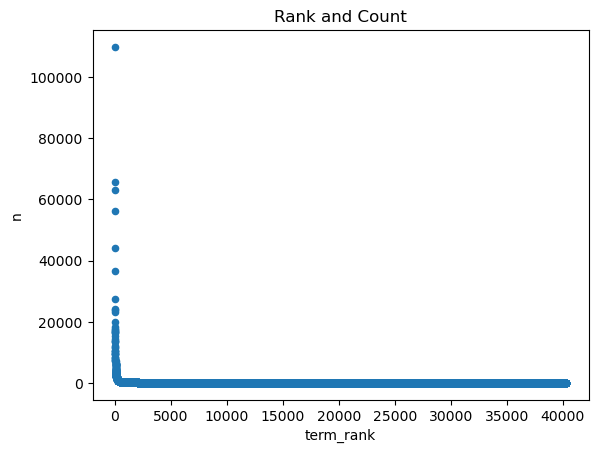

In [21]:
VOCAB.plot.scatter('term_rank', 'n', title="Rank and Count");

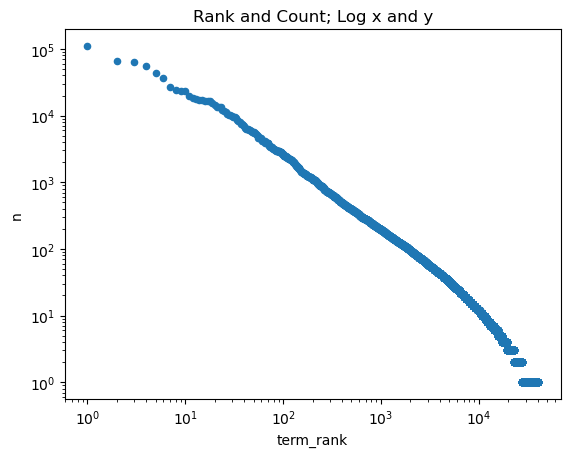

In [22]:
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Rank and Count; Log x and y");

## Create Alternate Rank

Raw term rank has the problem of arbitrarily assigning rank numbers to terms that have the same count -- essentially terms with the same count are assigned a value based on their alphanumeric sort order. So we come up with a different rank that is a function of term count only.

In [50]:
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'index':'term_rank2', 'count':'nn'})\
    .set_index('n')

In [51]:
VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1

# Compare Ranks

Note how the two ranks are related: the alternate rank groups more terms as frequency gets smaller.

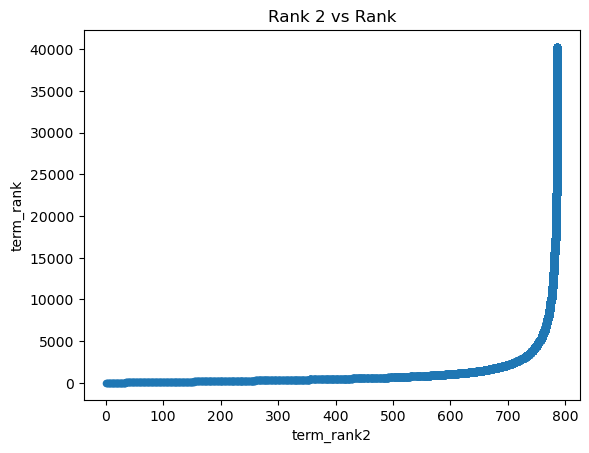

In [60]:
VOCAB.plot.scatter('term_rank2', 'term_rank', title="Rank 2 vs Rank");

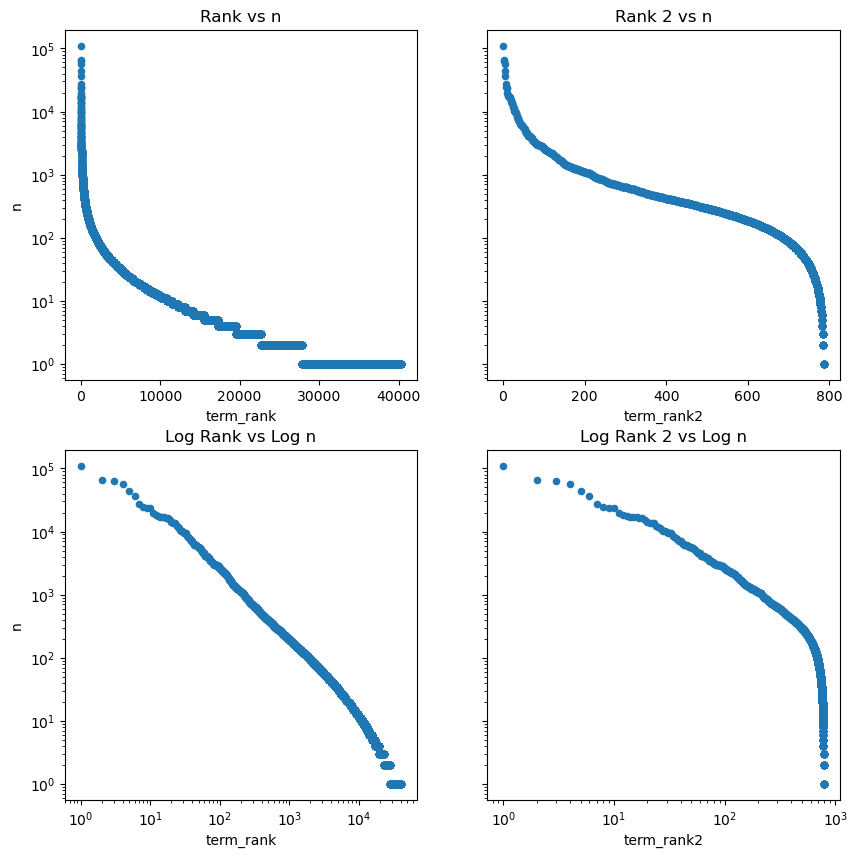

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharey=True)
VOCAB.plot.scatter('term_rank', 'n', title="Rank vs n", ax=axes[0,0])
VOCAB.plot.scatter('term_rank2', 'n', title="Rank 2 vs n", ax=axes[0,1]);
VOCAB.plot.scatter('term_rank', 'n', logx=True, logy=True, title="Log Rank vs Log n", ax=axes[1,0])
VOCAB.plot.scatter('term_rank2', 'n', logx=True, logy=True, title="Log Rank 2 vs Log n", ax=axes[1,1]);

## Compute Zipf's K

Now we see if K is linear as it's supposed to be.

In [54]:
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2

## Rank and Zipf $k$

$k$ is supposed to be constant.

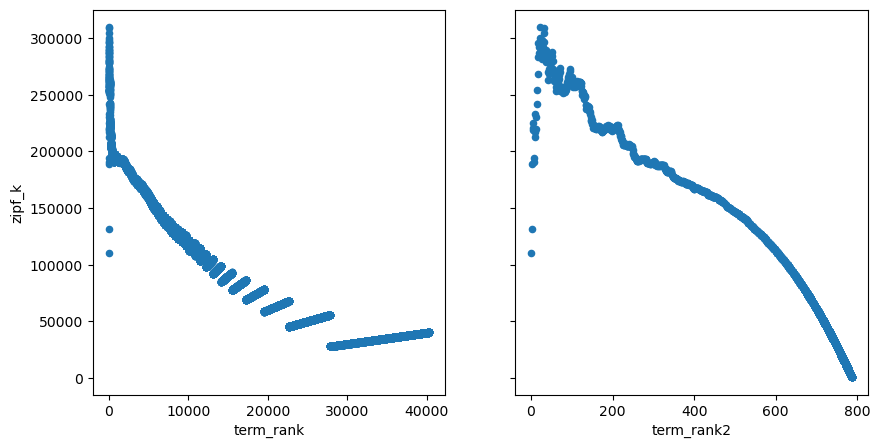

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
VOCAB.plot.scatter('term_rank', 'zipf_k', ax=axes[0])
VOCAB.plot.scatter('term_rank2', 'zipf_k2', ax=axes[1]);

## Demo Rank Index

We look at a sample drawn from rank increments to see global patterns in the corpus.

In [91]:
rank_index = [1, 2, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [92]:
DEMO = VOCAB.loc[VOCAB.term_rank.isin(rank_index)][['max_pos', 'p', 'term_rank', 'term_rank2', 'i', 'zipf_k', 'zipf_k2']]

In [93]:
DEMO.style.background_gradient(cmap='YlGnBu', high=.5)

## Rank and Information

Rank and information appear to be closely related.

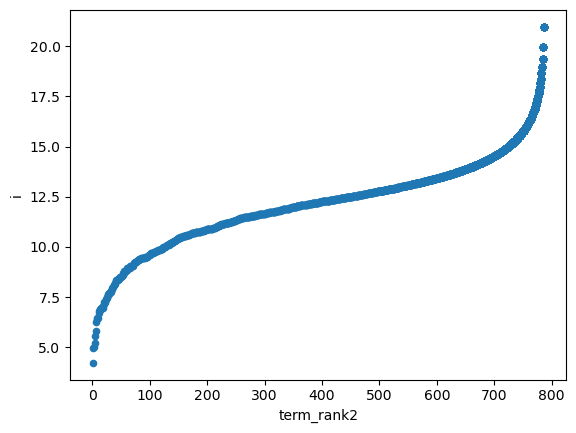

In [94]:
VOCAB.plot.scatter('term_rank2', 'i');

And, log $r$ tracks with $i$.

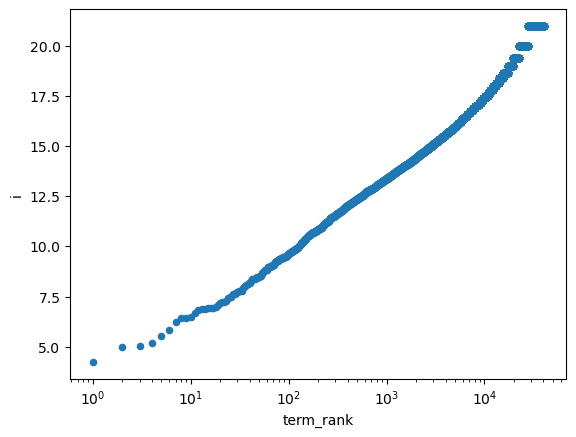

In [96]:
VOCAB.plot.scatter('term_rank', 'i', logx=True, logy=False);

In [97]:
VOCAB['log_r'] = np.log2(VOCAB.term_rank)

In [98]:
VOCAB[['log_r','i']].corr()

log_r         i
log_r  1.000000  0.981704
i      0.981704  1.000000

Also, $i$ vs $r$ provides an example of logistic growth. 

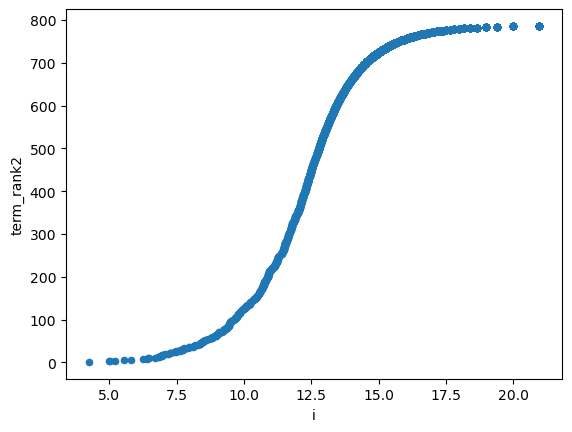

In [99]:
VOCAB.plot.scatter('i', 'term_rank2', logx=False, logy=False);

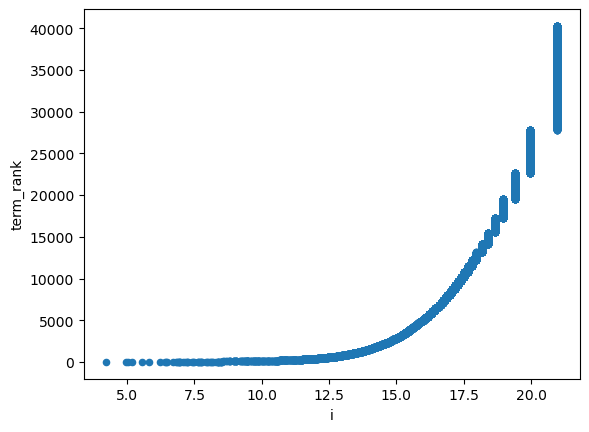

In [100]:
VOCAB.plot.scatter('i', 'term_rank', logx=False, logy=False);

## Observations

* Zipf's law sheds light on a basic structure of language -- the division between words that do **grammatical work** and those that do **semantic work**.
* Zipf's constant is not borne out by the data. 
* Zipf's rank order does not group words with the same count; so, we've created an alternate rank based on word count groupings.
* Information $i$ may be used as a replacement for rank when exploring corpus level significance trends.

# Extra: Open vs Closed Words

Let's look at the concept of open and closed words.

We can do this by compare the number of types (terms) and tokens for each POS.

In [101]:
POS_GROUP['n_terms'] = VOCAB.max_pos.value_counts() 
POS_GROUP['n_tokens'] = VOCAB.groupby('max_pos').n.sum()

In [105]:
POS_GROUP['type_token_ratio'] = POS_GROUP.n_terms / POS_GROUP.n_tokens

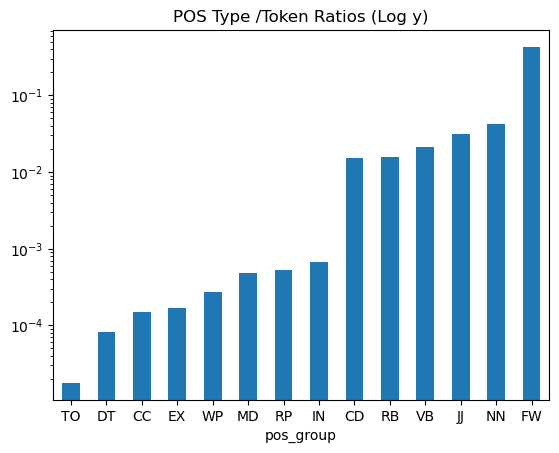

In [106]:
POS_GROUP.type_token_ratio.dropna().sort_values()\
    .plot.bar(logy=True, rot=0, title="POS Type /Token Ratios (Log y)");

We can see in both charts that two groups of words form.

| CLASS | TYPE/TOKEN | POS | THRESH |
|--|--|--|--|
| Open | High | Nouns, Adjectives, Verbs, Adverbs, Foreign Words* | $> 10^{-2}$ |
| Closed | Low | Function words | $< 10^{-3}$|

\*Foreigns words are typically nouns.

# Save

In [107]:
DEMO.to_csv(f"{output_dir}/{data_prefix}-DEMO.csv")
VOCAB.to_csv(f"{output_dir}/{data_prefix}-VOCAB_RANKED.csv")